# Data Exploration

In [1]:
# Import functions used in the different notebooks of the course project
%run Tools.ipynb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 1. Load Data

In [3]:
# Load the overfeat data
overfeat, pixels, labels, names = load_data()

# Print shapes
print('Overfeat shape:', overfeat.shape)
print('Pixels shape:', pixels.shape)
print('Labels shape:', labels.shape)
print('Names shape:', names.shape)

Overfeat shape: (5000, 4096)
Pixels shape: (5000, 3072)
Labels shape: (5000,)
Names shape: (4,)


## 2. Class Distribution

In [4]:
# Print class distribution
pd.value_counts(names[labels])

airplane    1250
car         1250
truck       1250
ship        1250
dtype: int64

We have exactly the same number of each classes (1250 => 25% images of each class).  
Perfect to avoid bias induced when some classes are most represented than others...

## 3. Most-frequent Baseline

In [5]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(overfeat, labels)
print('Most-frequent baseline accuracy (all data): {:.3f}'.format(dummy.score(overfeat, labels)))

Most-frequent baseline accuracy (all data): 0.250


In [6]:
# alternative method
print('Most-frequent baseline accuracy (all data): {:.3f}'.format(
    pd.value_counts(labels, normalize=True)[0]
))

Most-frequent baseline accuracy (all data): 0.250


It is an obvious result but note that we should try to keep this uniform distribution when we will split the data in train/validation sets (stratified splits). So, the most-frequent baseline accuracy on the validation set should also be equal (or near) to 0.25.

## 4. Plot some images

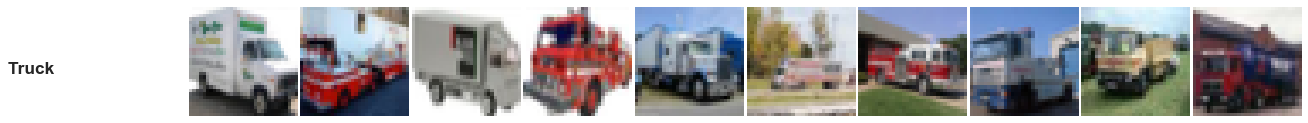

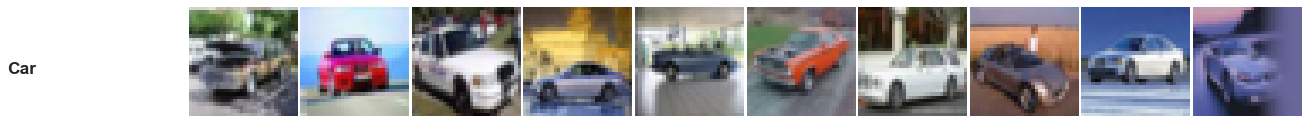

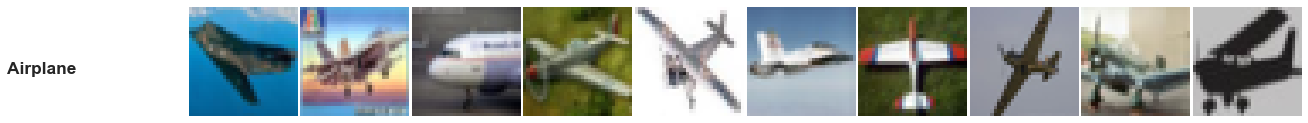

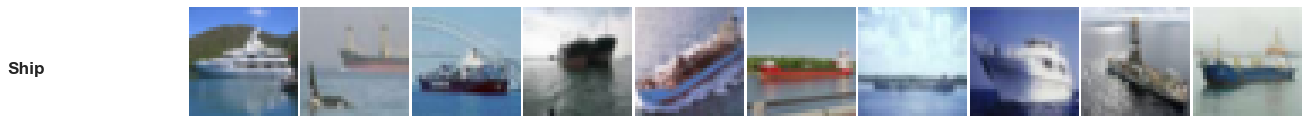

In [7]:
for label in np.unique(labels):
    # get 10 images with the corresponding label
    images = pixels[labels == label][:10]
    images = images.reshape(10, 32, 32, 3)

    # plot images
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 2))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i]/255)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
      
    plt.suptitle(names[label].capitalize(), x=0, y=0.5, ha='left', size='xx-large', weight='bold')
    plt.subplots_adjust(wspace=0, hspace=0)    
    plt.show()

Note that in general, subjects are well centered in the picture and surounded with a background, often quiet uniform in color and/or with large regions of the same color.

Intuition for later : try simplifying color palettes first and then use CNN to build the classifier

## 5. Overfeat features analysis

Before drawing the scree plot, let's look at the overfeat data. Concerning the pixels data, we already know that pixel values are in the [0, 255] range but we ignore everything about the range, mean and variance of the features in the overfeat matrix.

In [8]:
# compute feature statistics
df_stats_overfeat = pd.DataFrame({
    'mean': np.mean(overfeat, axis=0),
    'var': np.var(overfeat, axis=0),
    'std': np.std(overfeat, axis=0),
    'max': np.max(overfeat, axis=0),
    'min': np.min(overfeat, axis=0)
}, columns=['min', 'mean', 'max', 'var', 'std'])

print('Statistic overfeat shape:', df_stats_overfeat.shape)
df_stats_overfeat.head(5)

Statistic overfeat shape: (4096, 5)


,min,mean,max,var,std
0,-1.645508,3.136739,8.117188,1.555968,1.247384
1,-4.195312,-0.170242,2.611328,0.621713,0.788488
2,-3.755859,0.587786,2.992188,0.533814,0.730626
3,-4.542969,-0.409366,3.779297,0.625757,0.791048
4,-4.066406,-0.426974,3.593750,0.859153,0.926905


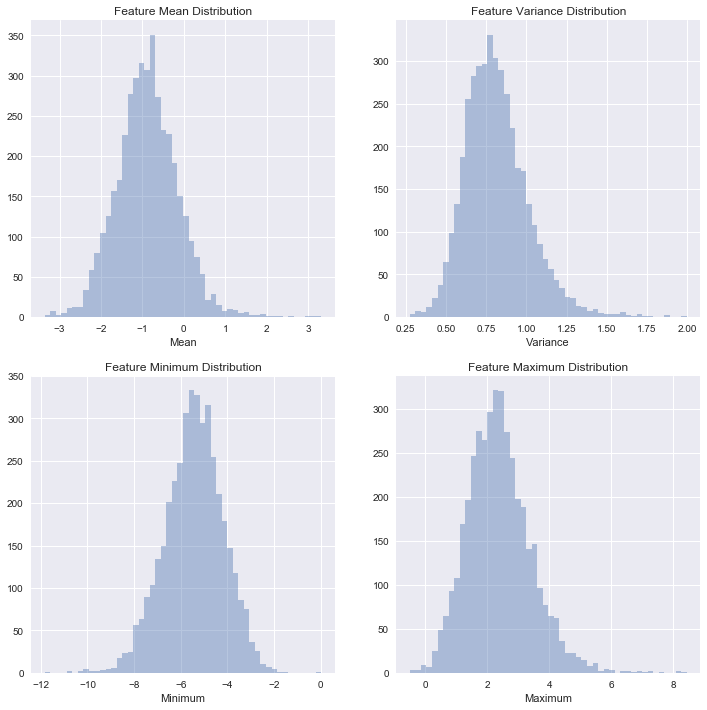

In [9]:
# plot feature statistics distributions
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

sns.distplot(df_stats_overfeat['mean'], kde=False, ax=ax[0, 0])
ax[0, 0].set(xlabel='Mean', title='Feature Mean Distribution')

sns.distplot(df_stats_overfeat['var'], kde=False, ax=ax[0, 1])
ax[0, 1].set(xlabel='Variance', title='Feature Variance Distribution')

sns.distplot(df_stats_overfeat['min'], kde=False, ax=ax[1, 0])
ax[1, 0].set(xlabel='Minimum', title='Feature Minimum Distribution')

sns.distplot(df_stats_overfeat['max'], kde=False, ax=ax[1, 1])
ax[1, 1].set(xlabel='Maximum', title='Feature Maximum Distribution')


plt.show()

We have no idea about the meaning of each features but it is clear that they don't have all the same variance.  
It will be important to normalize the data for our PCA analysis to avoid bias induced by the features with the highest variance.

## 6. OverFeat PCA Analysis

In [10]:
# Function to get the number of components that statisfy a proportion of variance explained
def get_pca_n_components(cumsum, threshold=0.95):
    idx = np.nonzero(cumsum >= threshold)[0][0] # nonzero return a tuple of arrays 
    return idx + 1

# Function that return the cumulative variance for a number of components
def get_cumulative_variance(cumsum, n_components):
    return cumsum[n_components - 1]

In [11]:
# Rescale data
scaler = StandardScaler()
X = scaler.fit_transform(overfeat)

In [12]:
# Principal Component Analysis
pca = PCA(n_components=None)
pca.fit(X, y=None)

# Variance explained & Cumulative Sum
pve = pca.explained_variance_ratio_
pve_cumsum = np.cumsum(pve)

# Print the number of components required to explain different proportion of variance
print('Number of components (variance >20%):', get_pca_n_components(pve_cumsum, threshold=0.2))
print('Number of components (variance >50%):', get_pca_n_components(pve_cumsum, threshold=0.5))
print('Number of components (variance >80%):', get_pca_n_components(pve_cumsum, threshold=0.8))
print('Number of components (variance >90%):', get_pca_n_components(pve_cumsum, threshold=0.9))
print('Number of components (variance >95%):', get_pca_n_components(pve_cumsum, threshold=0.95))
print('Number of components (variance >99%):', get_pca_n_components(pve_cumsum, threshold=0.99))

# Print the cumulated proportion of variance explained in the first two components
print('Cumulated proportion of variance explained in the first two components: {:.3f}'.format(
    get_cumulative_variance(pve_cumsum, n_components=2))
)

Number of components (variance >20%): 2
Number of components (variance >50%): 13
Number of components (variance >80%): 62
Number of components (variance >90%): 176
Number of components (variance >95%): 408
Number of components (variance >99%): 1072
Cumulated proportion of variance explained in the first two components: 0.235


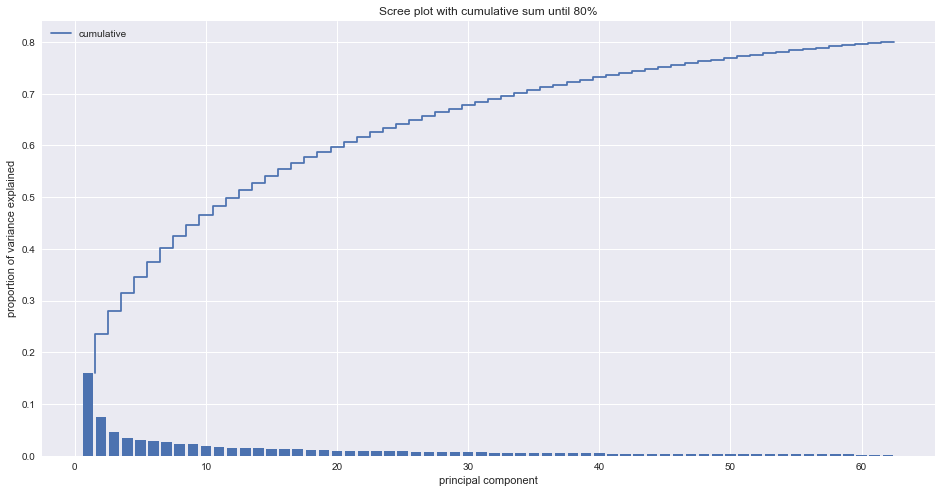

In [13]:
# Scree plot (80% variance)
plt.figure(figsize=(16, 8))
xcor = np.arange(1, 63)
plt.bar(xcor, pve[:62])  # bar plot
plt.step(xcor + 0.5, pve_cumsum[:62], label='cumulative')  # cumulative plot

plt.title('Scree plot with cumulative sum until 80%')
plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')
plt.legend()
plt.show()

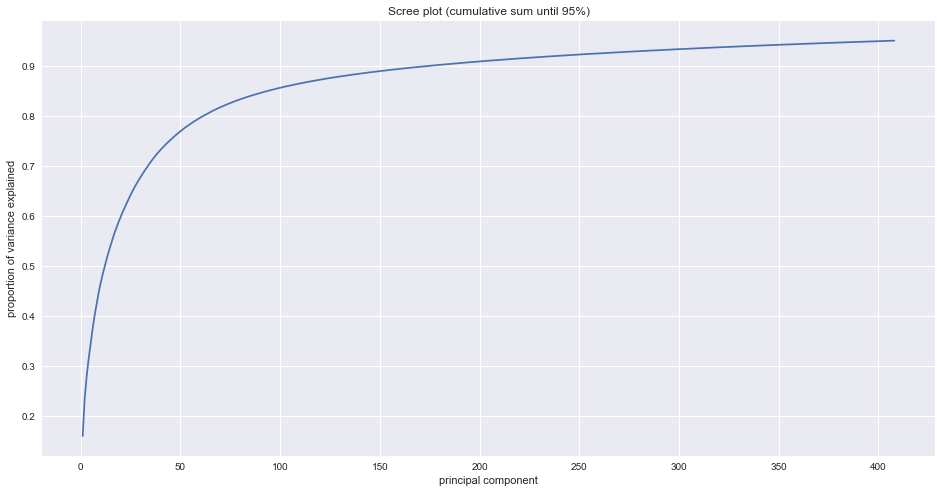

In [14]:
# Scree plot (95% variance)
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1, 409), pve_cumsum[:408])
plt.title('Scree plot (cumulative sum until 95%)')
plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')
plt.show()

## 7. 2D Plot OverFeat

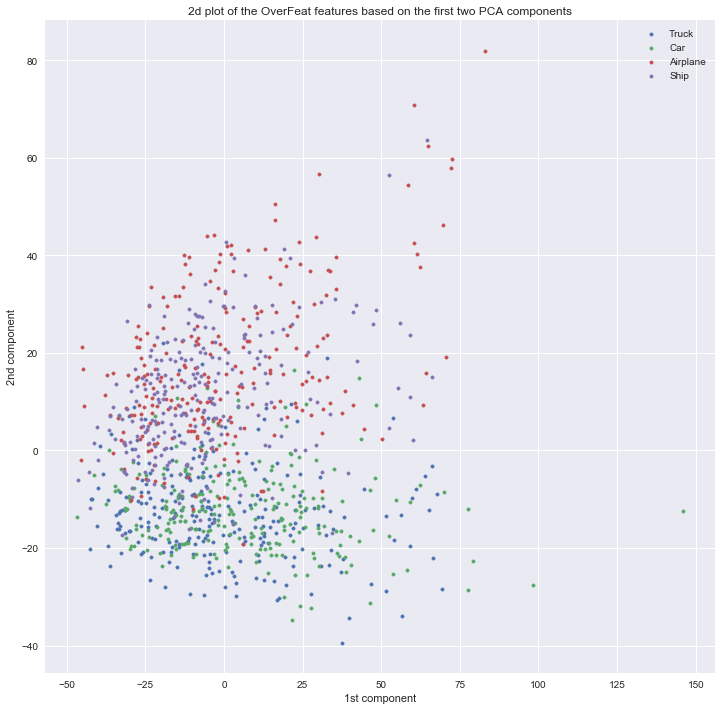

In [15]:
# PCA with two components
pca_2 = PCA(n_components=2, random_state=0)
X_2d = pca_2.fit_transform(X, y=None)

# 2D Plot (1000 observations, 250 observations per class)
plt.figure(figsize=(12, 12))
for label in np.unique(labels):
    idx = (labels == label)
    plt.scatter(X_2d[idx, 0][:250], X_2d[idx, 1][:250], s=12, label=names[label].capitalize())
    
plt.legend()
plt.title('2d plot of the OverFeat features based on the first two PCA components')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

We can see that the two components allow to split the ships and airplanes (upper cluster) from the trucks and cars (lower cluster). Howerver, it s clearly not sufficient to split the ship/airplane clusters and truck/car clusters that overlap. Models built from only two PCA components should have an accuracy around 50% that is already twice better than the most-frequent baseline accuracy !

It seems reasonable to think that the first two principal components are probably related to the background colors (blue, gray and more uniform for ship/planes than for cars/trucks).

## 8. 2D Plot image pixels

In the pixels matrix, features/pixel values have all the same meaning (feature values are individual channel pixel color encoded on 8 bits). So, it seems not indicated to apply the `StandardScaler` preprocessing step. Instead, we can center the value around 0 with a range of [-0.5, 0.5]. 

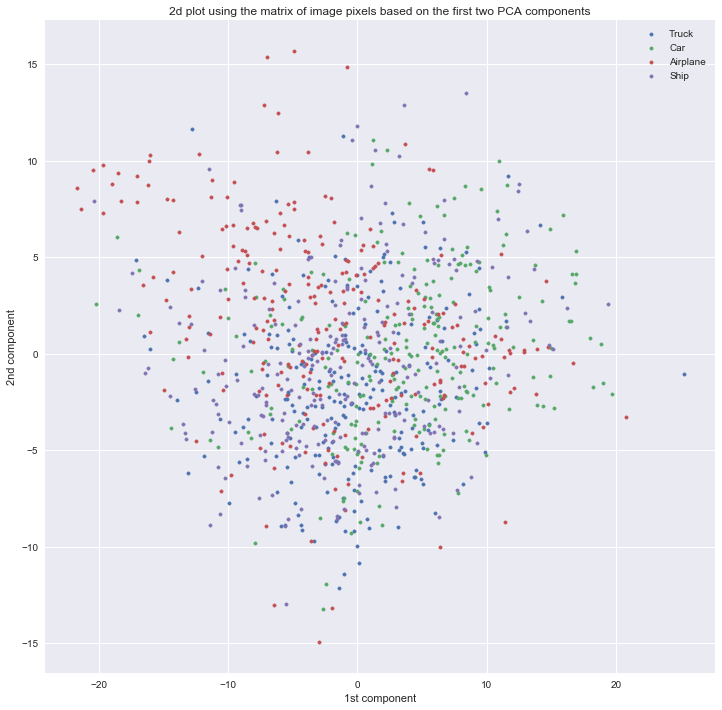

In [16]:
# normalization
X_pixels = (pixels - 128) / 255

# PCA
pca_pix = PCA(n_components=2, random_state=0)
X_pixels_2d = pca_pix.fit_transform(X_pixels, y=None)

# 2D Plot (1000 observations, 250 observations per class)
plt.figure(figsize=(12, 12))
for label in np.unique(labels):
    idx = (labels == label)
    plt.scatter(X_pixels_2d[idx, 0][:250], X_pixels_2d[idx, 1][:250], s=12, label=names[label].capitalize())
    
plt.legend()
plt.title('2d plot using the matrix of image pixels based on the first two PCA components')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

Here, we are missing the previous higher level features so the four classes are overlaping.  
At best, we can guess the tendency of the airplane and cars to be shrink orthogonaly. 

It is clear that to build our kNN, Tree, SVM classifiers, it will be better to use the overfeat higher level features than the source pixels.